In [1]:
from pprint import pprint
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()
import pickle as pickle
import re
from functools import reduce 
import operator
from sklearn.feature_extraction.text import TfidfVectorizer


In [2]:
%%time
# Read the Pre-Processed data
restaurant_file = pd.read_csv('processed_data/cleaned_restaurants.csv')
restaurant_file = restaurant_file.drop(labels="Unnamed: 0", axis=1)
review_file     = pd.read_csv('processed_data/cleaned_reviews.csv')
review_file     = review_file.drop(labels="Unnamed: 0", axis=1) 

Wall time: 38.1 s


In [259]:
%%time
# Convert in Unicode
# seperate topic relavant data from sentiment relavent data
review_file['topic_text'] = [u''+str(txt).replace('.','').replace('\\n','') for txt in review_file.topic_text]
review_file['sentiment_text'] = [u''+str(txt).replace('.','').replace('\\n','') for txt in review_file.sentiment_text]
review_file['text'] = [u''+str(txt) for txt in review_file.text]
review_file['review_length'] = review_file.text.map(len)

Wall time: 7.21 s


[Text(-12.415000000000013, 0.5, 'Number of Reviews')]

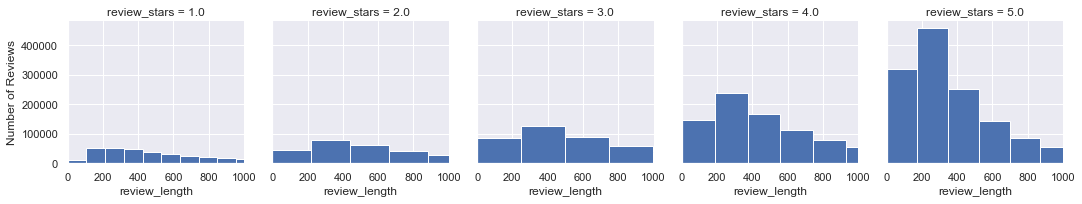

In [260]:
#let's check the distribution of the reviews by length of comments
ax = sns.FacetGrid(data=review_file, col='review_stars', xlim=(0, 1000)).map(plt.hist, 'review_length', bins=50)
ax.axes[0][0].set(ylabel='Number of Reviews')

In [261]:
#It's interesting that five star reivews are more verbose
#print(review_file.loc[review_file['review_stars']==1.0])


In [262]:
pos_reviews_sent  = review_file.sentiment_text[review_file.review_stars>3].values
neg_reviews_sent  = review_file.sentiment_text[review_file.review_stars<3].values
pos_reviews_topic = review_file.topic_text[review_file.review_stars>3].values
neg_reviews_topic = review_file.topic_text[review_file.review_stars<3].values

all_reviews_topic = review_file.topic_text.values
all_reviews_sent  = review_file.sentiment_text.values

print('Postive  Reviews: {:,}'.format(len(pos_reviews_topic)))
print('Negative Reviews: {:,}'.format(len(neg_reviews_topic)))

Postive  Reviews: 2,373,347
Negative Reviews: 693,326


In [263]:
pos_reviews_topic = pos_reviews_sent
neg_reviews_topic = neg_reviews_sent
all_reviews_topic = all_reviews_sent

In [264]:
#Take our additional stopwords
#from sklearn.feature_extraction import text
#extra_words = ['like','did','said','ok', 've', 'got']
#stop_words = text.ENGLISH_STOP_WORDS.union(extra_words)

In [265]:
stop_words = [line.rstrip('\n') for line in open('config/stopwords.txt', 'r', encoding='utf-8')] 
neg_words  = [line.rstrip('\n') for line in open('config/stopwords.txt', 'r', encoding='utf-8')]
stop_words = stop_words + neg_words

In [266]:
# Set max features for data vertorication
max_features=5000

In [267]:
# Tokenize the text
def tokenizer(x):
    return ( w for w in str(x).split() if len(w) >3)

In [268]:
%%time
#TF-IDF
# Create a vectorizer object to generate term document counts
tfidf_pos = TfidfVectorizer(stop_words=stop_words, min_df=10, max_df=0.5,
                        tokenizer = tokenizer,ngram_range=(1,1), max_features=max_features)
                        #ngram_range=(1,1), token_pattern='[a-z][a-z]+', max_features=max_features)

tfidf_neg = TfidfVectorizer(stop_words=stop_words, min_df=10, max_df=0.5, 
                        tokenizer = tokenizer,ngram_range=(1,1), max_features=max_features)
                        #ngram_range=(1,1), token_pattern='[a-z][a-z]+', max_features=max_features)

tfidf_all = TfidfVectorizer(stop_words=stop_words, min_df=10, max_df=0.5, 
                        tokenizer = tokenizer,ngram_range=(1,1), max_features=max_features)
                        #ngram_range=(1,1), token_pattern='[a-z][a-z]+', max_features=max_features)

#  Stats
## Wall time: 2min 47s

Wall time: 0 ns


In [269]:
%%time
# Vectorize Data
neg_vectors  = tfidf_neg.fit_transform(neg_reviews_topic)
pos_vectors  = tfidf_pos.fit_transform(pos_reviews_topic)
all_vectors  = tfidf_all.fit_transform(all_reviews_topic)

#  Stats
## Wall time: 1min 25s

Wall time: 2min 49s


In [270]:
with open('pickles/topic_term_vector_all.pk','wb') as f:
    pickle.dump(tfidf_all, f)
with open('pickles/topic_term_vector_pos.pk','wb') as f:
    pickle.dump(tfidf_pos, f)
with open('pickles/topic_term_vector_neg.pk','wb') as f:
    pickle.dump(tfidf_neg, f)

In [271]:
neg_feature_names = np.array(tfidf_neg.get_feature_names())
pos_feature_names = np.array(tfidf_pos.get_feature_names())
all_feature_names = np.array(tfidf_all.get_feature_names())

In [272]:
#with open('pickles/neg_topic_vectors_'+str(max_features)+'.pk', 'wb') as fin:
#    pickle.dump(neg_vectors, fin)
with open('pickles/neg_topic_features_'+str(max_features)+'.pk', 'wb') as fin:
    pickle.dump(np.array(tfidf_neg.get_feature_names()), fin)    

In [273]:
#with open('pickles/pos_topic_vectors_'+str(max_features)+'.pk', 'wb') as fin:
#    pickle.dump(pos_vectors, fin)
with open('pickles/pos_topic_features_'+str(max_features)+'.pk', 'wb') as fin:
    pickle.dump(np.array(tfidf_pos.get_feature_names()), fin)    

In [274]:
#with open('pickles/all_topic_vectors_'+str(max_features)+'.pk', 'wb') as fin:
#    pickle.dump(all_vectors, fin)
with open('pickles/all_topic_features_'+str(max_features)+'.pk', 'wb') as fin:
    pickle.dump(np.array(tfidf_all.get_feature_names()), fin) 

In [275]:
#with open('pickles/neg_topic_vectors_'+str(max_features)+'.pk', 'rb') as fin:
#    neg_vectors = pickle.load(fin)
with open('pickles/neg_topic_features_'+str(max_features)+'.pk', 'rb') as fin:
    neg_feature_names = pickle.load(fin)

In [276]:
#with open('pickles/pos_topic_vectors_'+str(max_features)+'.pk', 'rb') as fin:
#    pos_vectors = pickle.load(fin)
with open('pickles/pos_topic_features_'+str(max_features)+'.pk', 'rb') as fin:
    pos_feature_names = pickle.load(fin)

In [277]:
#with open('pickles/all_topic_vectors_'+str(max_features)+'.pk', 'rb') as fin:
#    all_vectors = pickle.load(fin)
with open('pickles/all_topic_features_'+str(max_features)+'.pk', 'rb') as fin:
    all_feature_names = pickle.load(fin)

In [278]:
all_vectors.get_shape()

(3527902, 5000)

# LSA

In [285]:
NUM_TOPICS = 50

In [286]:
%%time
# LSA
from gensim import corpora, models, similarities, matutils

# Convert sparse matrix of counts to a gensim corpus
# Need to transpose it for gensim which wants terms by docs instead of docs by terms
tfidf_pos_corpus = matutils.Sparse2Corpus(pos_vectors.transpose())
tfidf_neg_corpus = matutils.Sparse2Corpus(neg_vectors.transpose())
tfidf_all_corpus = matutils.Sparse2Corpus(all_vectors.transpose())

# Row indices
id2word_pos = dict((v,k) for k,v in tfidf_pos.vocabulary_.items())
id2word_neg = dict((v,k) for k,v in tfidf_neg.vocabulary_.items())
id2word_all = dict((v,k) for k,v in tfidf_all.vocabulary_.items())

# This is a hack for Python 3!
id2word_pos = corpora.Dictionary.from_corpus(tfidf_pos_corpus, id2word=id2word_pos)
id2word_neg = corpora.Dictionary.from_corpus(tfidf_neg_corpus, id2word=id2word_neg)
id2word_all = corpora.Dictionary.from_corpus(tfidf_all_corpus, id2word=id2word_all)

#  Stats
## Wall time: 1min 21s

Wall time: 1min 45s


In [287]:
%%time
# create LSA model
lsi_pos = models.LsiModel(tfidf_pos_corpus, id2word=id2word_pos, num_topics=NUM_TOPICS)
lsi_neg = models.LsiModel(tfidf_neg_corpus, id2word=id2word_neg, num_topics=NUM_TOPICS)
lsi_all = models.LsiModel(tfidf_all_corpus, id2word=id2word_all, num_topics=NUM_TOPICS)

#  Stats
## Wall time: 13min 3s

Wall time: 7min 33s


In [288]:
%%time
# negative values in LSA topics are annoying
# let's see if we can fix that with NMF
from sklearn.decomposition import NMF

Wall time: 0 ns


In [289]:
%%time
# change num_topics
num_topics = NUM_TOPICS

In [290]:
%%time
nmf_pos = NMF(n_components=num_topics)
W_pos = nmf_pos.fit_transform(pos_vectors)
H_pos = nmf_pos.components_

In [291]:
%%time
nmf_neg = NMF(n_components=num_topics)
W_neg = nmf_neg.fit_transform(neg_vectors)
H_neg = nmf_neg.components_

In [292]:
%%time
nmf_all = NMF(n_components=num_topics)
W_all = nmf_all.fit_transform(all_vectors)
H_all = nmf_all.components_

### Checkpointing: dump processed won in pickles

In [301]:
# Save models for future use
with open('pickles/neg_topic_model.pk', 'wb') as fin:
    pickle.dump(lsi_neg, fin)
with open('pickles/pos_topic_model.pk', 'wb') as fin:
    pickle.dump(lsi_pos, fin)
with open('pickles/all_topic_model.pk', 'wb') as fin:
    pickle.dump(lsi_all, fin)        

In [302]:
# Save models for future use
with open('pickles/neg_nmf_model.pk', 'wb') as fin:
    pickle.dump(nmf_neg, fin)
with open('pickles/pos_nmf_model.pk', 'wb') as fin:
    pickle.dump(nmf_pos, fin)
with open('pickles/all_nmf_model.pk', 'wb') as fin:
    pickle.dump(nmf_all, fin)

##### Load saved pickles and resume

In [345]:
max_features=2500
num_topics  =100

In [346]:
with open('pickles/all_topic_model.pk', 'rb') as fin:
    lsi_all = pickle.load(fin)
with open('pickles/pos_topic_model.pk', 'rb') as fin:
    lsi_pos = pickle.load(fin)
with open('pickles/neg_topic_model.pk', 'rb') as fin:
    lsi_neg = pickle.load(fin)

In [347]:
with open('pickles/neg_nmf_model.pk', 'rb') as fin:
    nmf_neg = pickle.load(fin)
with open('pickles/pos_nmf_model.pk', 'rb') as fin:
    nmf_pos = pickle.load(fin)
with open('pickles/all_nmf_model.pk', 'rb') as fin:
    nmf_all = pickle.load(fin)

In [348]:
with open('pickles/all_topic_features_'+str(max_features)+'.pk', 'rb') as fin:
    all_feature_names = pickle.load(fin)

In [349]:
with open('pickles/pos_topic_features_'+str(max_features)+'.pk', 'rb') as fin:
    pos_feature_names = pickle.load(fin)

In [350]:
with open('pickles/neg_topic_features_'+str(max_features)+'.pk', 'rb') as fin:
    neg_feature_names = pickle.load(fin)

In [352]:
with open('pickles/topic_term_vector_all.pk', 'rb') as fin:
    term_vector = pickle.load(fin)

In [334]:
def get_topic_list(model, feature_names, num_topics, no_top_words):
    lst = []
    for topic_idx, topic in enumerate(model.components_):
        if topic_idx < num_topics:
            #print("{:11}".format("Topic %d:" %(topic_idx)), end='')
            #print(", ".join(['{:04.3f}*'.format(topic[i])+feature_names[i] for i in topic.argsort()[:-no_top_words-1:-1]]))
            lst.append('/'.join(sort_list([feature_names[i]+" " for i in topic.argsort()[:-no_top_words-1:-1]])))
    return((list((set(lst)))))

In [335]:
def get_topic_map(model, feature_names, num_topics, no_top_words):
    dicty = {}
    for topic_idx, topic in enumerate(model.components_):
        if topic_idx < num_topics:
            dicty[topic_idx]='/'.join(sort_list([feature_names[i]+" " for i in topic.argsort()[:-no_top_words-1:-1]]))
    return dicty

In [336]:
def display_topics(model, feature_names, num_topics, no_top_words):
    for topic_idx, topic in enumerate(model.components_):
        if topic_idx < num_topics:
            print("{:11}".format("Topic %d:" %(topic_idx)), end='')
            print(", ".join(['{:04.3f}*'.format(topic[i])+feature_names[i] \
                             for i in topic.argsort()[:-no_top_words-1:-1]]))

In [337]:
def topic_to_text(topic):
    str = ''
    for elem in list(topic)[1].split('+')[:6]:
        str+= '/'.join(re.findall(r'"([^"]*)"', elem))+' '
    topics.append(str)

In [338]:
def sort_list(lst):
    return list(sorted(set(reduce(operator.concat, lst).split())))

In [315]:
topic_list = []
no_topics = num_topics
no_top_words = 4

topic_list.extend(get_topic_list(nmf_all, all_feature_names, no_topics, no_top_words))
topic_list.extend(get_topic_list(nmf_pos, pos_feature_names, no_topics, no_top_words))
topic_list.extend(get_topic_list(nmf_neg, neg_feature_names, no_topics, no_top_words))

['reservation/seat/table/waiter', 'atmosphere/favorite/husband/love', 'atmosphere/food/good-service/quality', 'crust/good-pizza/pizza/slice', 'good/mexican-food/not-great/town', 'bacon/burger/good-burger/shake', 'atmosphere/definitely/great/highly-recommend', 'chef/fish/sashimi/sushi', 'bill/charge/dollar/spend', 'shrimp/street/taco/tuesday', 'burrito/chip/fish/salsa', 'feel/like/more/much', 'chicken/rice/waffle/wing', 'couple/second-time/time/visit', 'customer/great-customer/service/slow', 'bread/pulled-pork/sandwich/turkey', 'attentive/friendly/helpful/staff', 'absolutely/amazing/highly-recommend/not-wait', 'atmosphere/enjoy/experience/meal', 'absolutely/definitely/delicious/highly-recommend', 'great-atmosphere/great-food/great-service/highly-recommend', 'leave/manager/people/tell', 'dinner/lunch/special/today', 'caesar/dress/pasta/salad', 'dish/noodle/rice/soup', 'hour/line/minute/wait', 'breakfast/brunch/coffee/pancake', 'item/menu/offer/option', 'bartender/drink/night/refill', 'be

In [316]:
with open('config/topic_map.csv','w+') as f:
    f.write('\n'.join(topic_list))

In [313]:
display_topics(nmf_all, all_feature_names, no_topics, no_top_words)

Topic 0:   33.337*table, 5.764*seat, 3.771*waiter, 3.330*reservation
Topic 1:   21.926*love, 0.749*favorite, 0.729*atmosphere, 0.612*husband
Topic 2:   17.797*food, 0.987*quality, 0.644*good-service, 0.490*atmosphere
Topic 3:   12.232*pizza, 1.139*crust, 0.937*good-pizza, 0.929*slice
Topic 4:   12.691*good, 0.303*mexican-food, 0.232*not-great, 0.201*town
Topic 5:   10.957*burger, 0.773*good-burger, 0.666*shake, 0.609*bacon
Topic 6:   24.622*great, 0.568*atmosphere, 0.476*definitely, 0.397*highly-recommend
Topic 7:   13.027*sushi, 1.141*chef, 0.969*sashimi, 0.784*fish
Topic 8:   12.118*dollar, 0.899*charge, 0.665*bill, 0.599*spend
Topic 9:   20.075*taco, 1.211*shrimp, 1.145*tuesday, 1.138*street
Topic 10:  6.234*chip, 5.259*fish, 4.631*salsa, 3.989*burrito
Topic 11:  17.191*like, 3.683*feel, 1.813*more, 0.678*much
Topic 12:  11.849*chicken, 1.325*waffle, 0.648*wing, 0.531*rice
Topic 13:  12.010*time, 0.805*visit, 0.444*couple, 0.388*second-time
Topic 14:  13.629*service, 1.709*customer,

In [314]:
get_topic_map(nmf_all, all_feature_names, no_topics, no_top_words)

{0: 'reservation/seat/table/waiter',
 1: 'atmosphere/favorite/husband/love',
 2: 'atmosphere/food/good-service/quality',
 3: 'crust/good-pizza/pizza/slice',
 4: 'good/mexican-food/not-great/town',
 5: 'bacon/burger/good-burger/shake',
 6: 'atmosphere/definitely/great/highly-recommend',
 7: 'chef/fish/sashimi/sushi',
 8: 'bill/charge/dollar/spend',
 9: 'shrimp/street/taco/tuesday',
 10: 'burrito/chip/fish/salsa',
 11: 'feel/like/more/much',
 12: 'chicken/rice/waffle/wing',
 13: 'couple/second-time/time/visit',
 14: 'customer/great-customer/service/slow',
 15: 'bread/pulled-pork/sandwich/turkey',
 16: 'attentive/friendly/helpful/staff',
 17: 'absolutely/amazing/highly-recommend/not-wait',
 18: 'atmosphere/enjoy/experience/meal',
 19: 'absolutely/definitely/delicious/highly-recommend',
 20: 'great-atmosphere/great-food/great-service/highly-recommend',
 21: 'leave/manager/people/tell',
 22: 'dinner/lunch/special/today',
 23: 'caesar/dress/pasta/salad',
 24: 'dish/noodle/rice/soup',
 25: 'h

In [317]:
with open('config/all_topics.txt', 'w') as f:
    f.write('\n'.join([str(key)+";"+str(value) for key, value in get_topic_map(nmf_all, all_feature_names, no_topics, no_top_words).items()]))

In [318]:
with open('config/neg_topics.txt', 'w') as f:
    f.write('\n'.join([str(key)+";"+str(value) for key, value in get_topic_map(nmf_neg, neg_feature_names, no_topics, no_top_words).items()]))

In [319]:
with open('config/pos_topics.txt', 'w') as f:
    f.write('\n'.join([str(key)+";"+str(value) for key, value in get_topic_map(nmf_pos, pos_feature_names, no_topics, no_top_words).items()]))

In [1]:
#with open('config/topics.csv', 'w+') as f:
#    f.write('\n'.join(topic_list))

## Load everything

In [3]:
from pprint import pprint
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()
import pickle as pickle
import re
from functools import reduce 
import operator
from sklearn.feature_extraction.text import TfidfVectorizer

In [4]:
%%time
# Read the Pre-Processed data
restaurant_file = pd.read_csv('processed_data/cleaned_restaurants.csv')
restaurant_file = restaurant_file.drop(labels="Unnamed: 0", axis=1)
review_file     = pd.read_csv('processed_data/cleaned_reviews.csv')
review_file     = review_file.drop(labels="Unnamed: 0", axis=1) 

review_file['topic_text'] = [u''+str(txt).replace('.','').replace('\\n','') for txt in review_file.topic_text]
review_file['sentiment_text'] = [u''+str(txt).replace('.','').replace('\\n','') for txt in review_file.sentiment_text]
review_file['text'] = [u''+str(txt) for txt in review_file.text]
review_file['review_length'] = review_file.text.map(len)

Wall time: 48.9 s


In [5]:
def tokenizer(x):
    return ( w for w in str(x).split() if len(w) >3)

In [6]:
max_features=5000

with open('pickles/neg_topic_features_'+str(max_features)+'.pk', 'rb') as fin:
    neg_feature_names = pickle.load(fin)
with open('pickles/pos_topic_features_'+str(max_features)+'.pk', 'rb') as fin:
    pos_feature_names = pickle.load(fin)
with open('pickles/all_topic_features_'+str(max_features)+'.pk', 'rb') as fin:
    all_feature_names = pickle.load(fin)

In [7]:
topic_desc_map = {}
with open('config/topic_map.txt', 'r') as f:
    topic_desc_map = {line.split(';')[0]: line.split(';')[1].replace('\n','') for line in f.readlines()}

neg_topic_map = {}
pos_topic_map = {}
all_topic_map = {}

with open('config/pos_topics.txt', 'r') as f:
    pos_topic_map = {line.split(';')[0]: line.split(';')[1].replace('\n','') for line in f.readlines()}
with open('config/neg_topics.txt', 'r') as f:
    neg_topic_map = {line.split(';')[0]: line.split(';')[1].replace('\n','') for line in f.readlines()}
with open('config/all_topics.txt', 'r') as f:
    all_topic_map = {line.split(';')[0]: line.split(';')[1].replace('\n','') for line in f.readlines()}
    
with open('pickles/topic_term_vector_all.pk', 'rb') as fin:
    term_vector = pickle.load(fin)
    
with open('pickles/all_nmf_model.pk', 'rb') as fin:
    nmf_all = pickle.load(fin)

In [8]:
new_review_text = review_file['text'][0]
new_topic_text  = review_file['topic_text'][0]

In [9]:
print(new_review_text.replace('\\n','\n'))

My girlfriend and I went for dinner at Emerald Chinese after a Thursday night workout.

We arrived around 7:30pm and were seated after a short wait.  After browsing the menu and a brief discussion with our waiter, we ordered seafood noodles and a 3 item mix meat plate (BBQ pork, chicken, and duck)

The food came soon thereafter and it was hot and delicious.  There was large portions and lots of seafood in the seafood noodles and the mix meat plate came with good cuts of meat and the correct sauces.

After the meal, we received fortune cookies for dessert.


Food
The food was good quality.  Ingredients tasted fresh and dishes tasted well made.  Food is above average but nothing stood out even though I was quite hungry.

Price
Price is high in comparative to other Chinese cuisine, and comparable to large western restaurant chains.

Service:
The service is average to slightly below average.  A common malaise of chinese restaurants is poor service where the waiter/waitresses are overworked

In [10]:
print(new_topic_text.replace('\\n','\n'))

girlfriend dinner thursday night workout arrive browse menu brief_discussion waiter seafood noodle item mix meat plate bbq pork chicken duck food lot seafood seafood noodle mix meat plate meat meal receive food food ingredient taste taste food price price service service average waiter waitress overwork exception wait staff rush service need meet staff rush decor navigate table receive pay meal


In [11]:
new_text_vec = term_vector.transform([new_topic_text])

In [12]:
text_all = nmf_all.transform(new_text_vec)

In [13]:
np.argmax(text_all)

48

In [14]:
all_topic_map[str(np.argmax(text_all))]

'flavor/meat/sauce/wing'

In [15]:
topic_desc_map[all_topic_map[str(np.argmax(text_all))]]

'Food veriety & flavors'

In [16]:
text_pos = nmf_pos.transform(new_text_vec)

NameError: name 'nmf_pos' is not defined

In [ ]:
all_topic_map[str(np.argmax(text_pos))]

In [ ]:
topic_desc_map[all_topic_map[str(np.argmax(text_pos))]]

In [ ]:
text_neg = nmf_neg.transform(new_text_vec)